<a href="https://colab.research.google.com/github/meisamgh/Machine_Learning_Trading/blob/main/BackTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410 kB 4.2 MB/s 


In [ ]:
!pip install yfinance
!pip install pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 25.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +


[*********************100%***********************]  1 of 1 completed


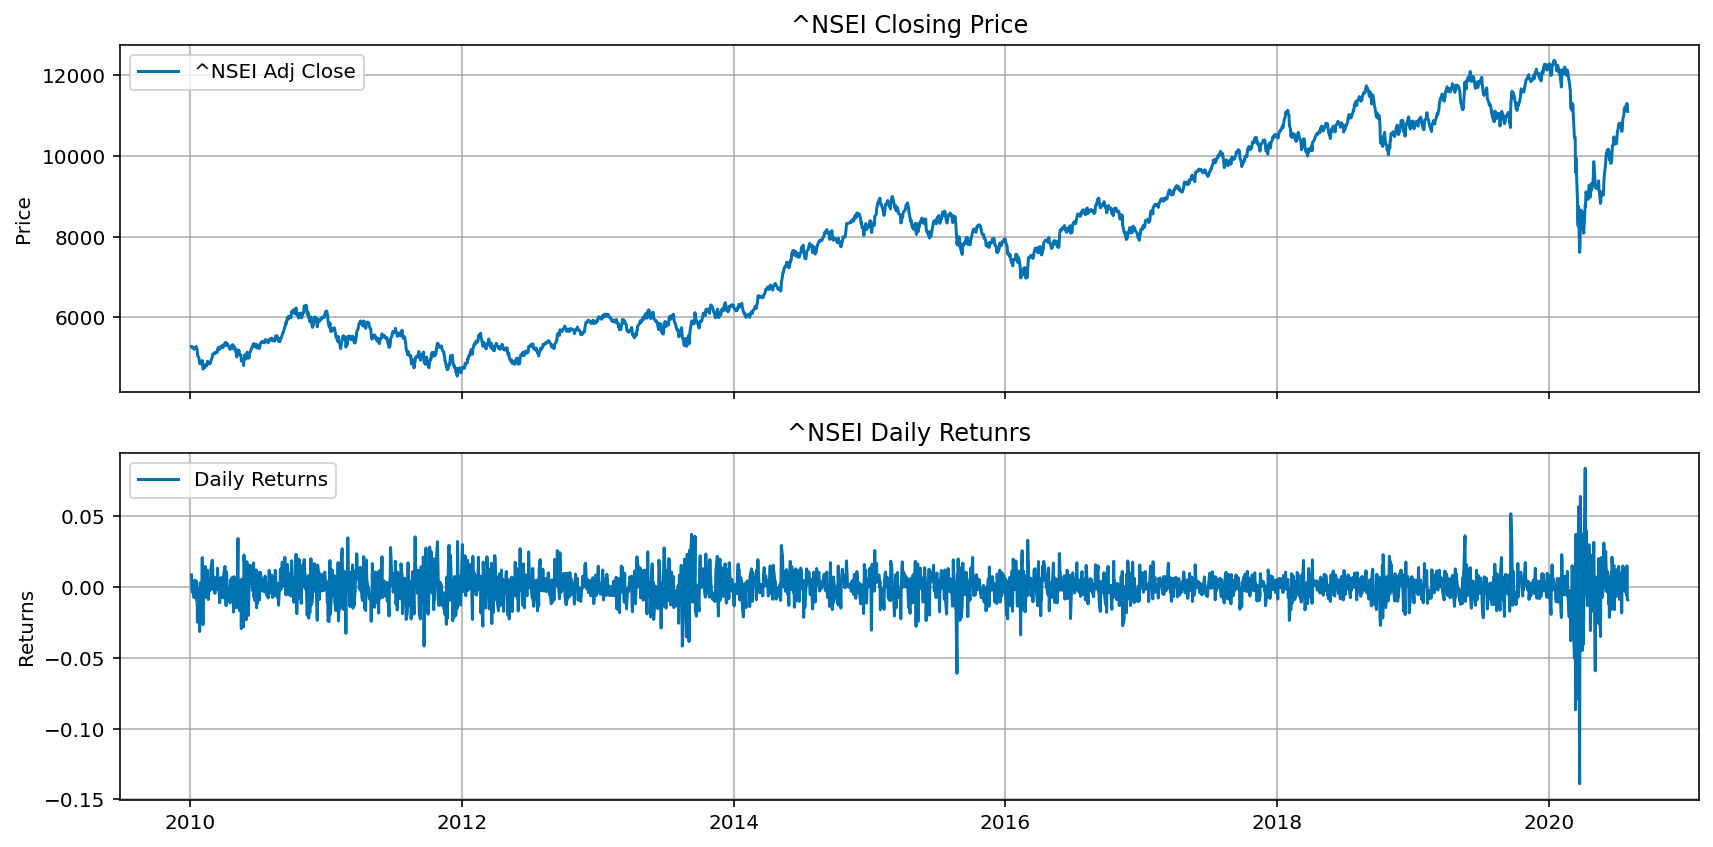

In [ ]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings
# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
#warnings.filterwarnings(['ignore'])
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)
# download ticker ‘Adj Close’ price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()
plt.tight_layout();
#plt.savefig('images/chart1', dpi=300)

In [ ]:
# define the number of lags
lags = [1, 2, 3, 4, 5]
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.dropna(inplace=True)
stock.head(2)
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
create_bins(stock)
stock[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2010-01-12,0.000886,-0.003493,-0.003547,0.000739,0.008696,1,0,0,1,1
2010-01-13,-0.007457,0.000886,-0.003493,-0.003547,0.000739,0,1,0,0,1



Total Returns: 

returns                   2.114937
strategy_log_reg          2.262539
strategy_gauss_nb         1.846504
strategy_svm              8.130174
strategy_random_forest    6.317187
strategy_MLP              5.863499
dtype: float64

Annual Volitility:
Number of trades SVM =  1045
Number of trades Ramdom Forest =  1018


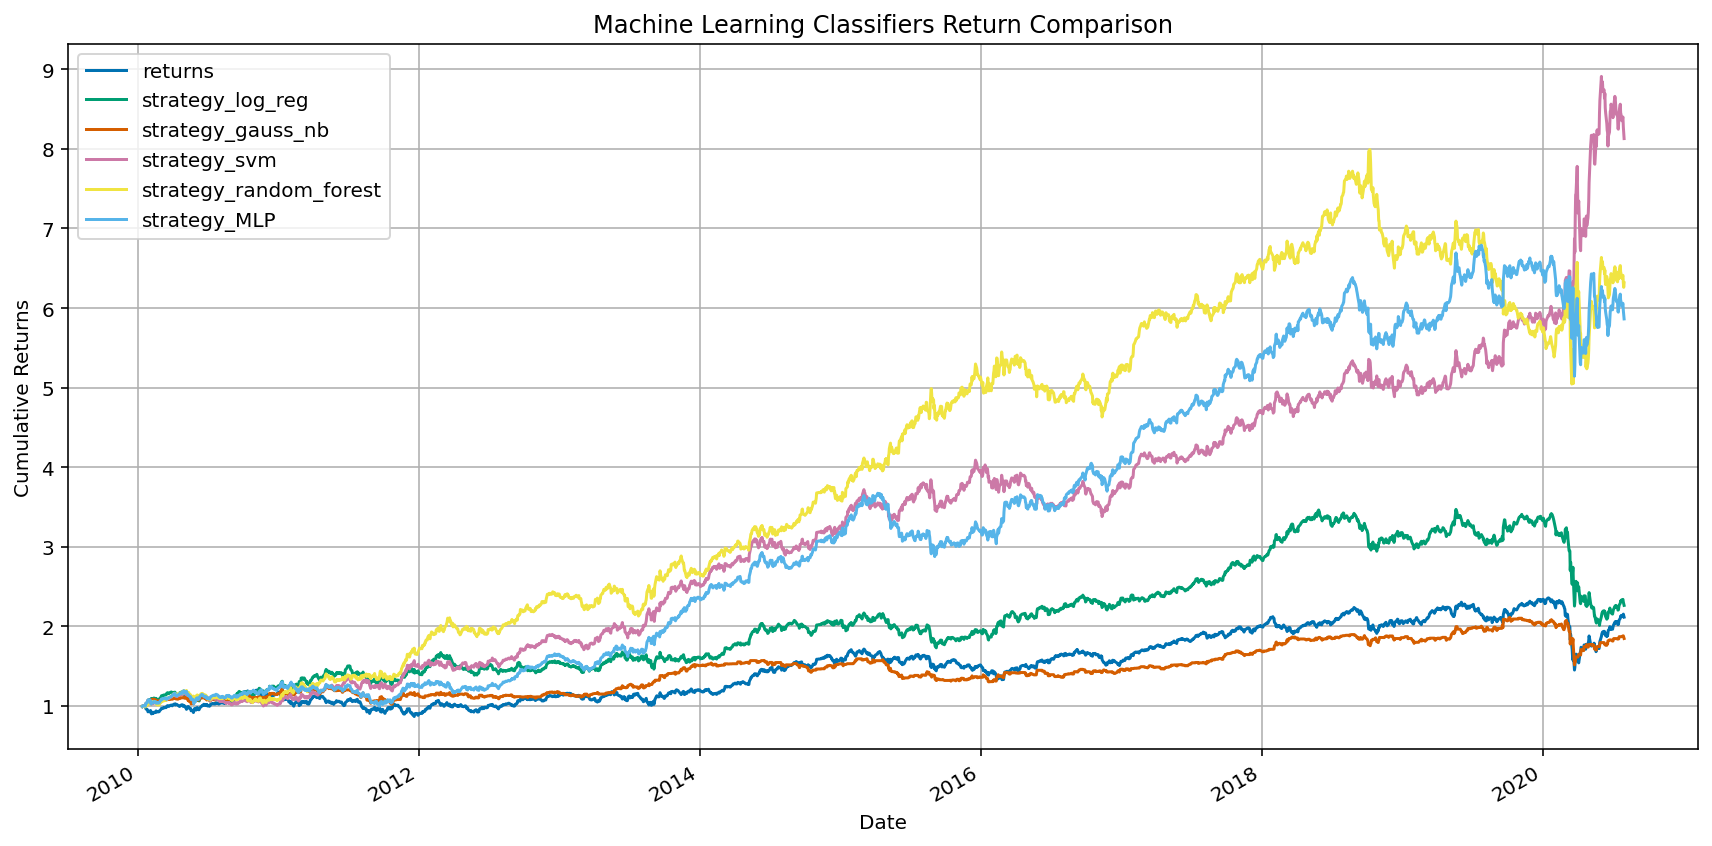

In [ ]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')
# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
stock[strategy_rtn].std() * 252 ** 0.5
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();

In [ ]:
# fetch the daily pricing data from yahoo finance
prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
prices.head(3)
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

[*********************100%***********************]  1 of 1 completed


In [ ]:
prices.head()

,predicted,open,high,low,close,volume
Date,,,,,,
2010-01-12,-0.007457,5251.100098,5300.500000,5200.950195,5210.399902,0
2010-01-13,0.004510,5212.600098,5239.200195,5169.549805,5233.950195,0
2010-01-14,0.004946,5234.500000,5272.850098,5232.500000,5259.899902,0
2010-01-15,-0.001465,5259.899902,5279.850098,5242.450195,5252.200195,0
2010-01-18,0.004303,5253.649902,5292.500000,5228.950195,5274.850098,0


In [ ]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [ ]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = True, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-01-13, BUY CREATED --- Size: 19, Cash: 100000.00, Open: 5212.60009765625, Close: 5233.9501953125
2010-01-13, BUY EXECUTED --- Price: 5212.60, Cost: 99039.40,Commission: 99.04
2010-01-15, SELL CREATED --- Size: 19
2010-01-15, SELL EXECUTED --- Price: 5259.90, Cost: 99039.40,Commission: 99.94
2010-01-15, OPERATION RESULT --- Gross: 898.70, Net: 699.72
2010-01-18, BUY CREATED --- Size: 19, Cash: 100699.72, Open: 5253.64990234375, Close: 5274.85009765625
2010-01-18, BUY EXECUTED --- Price: 5253.65, Cost: 99819.35,Commission: 99.82
2010-01-19, SELL CREATED --- Size: 19
2010-01-19, SELL EXECUTED --- Price: 5274.20, Cost: 99819.35,Commission: 100.21
2010-01-19, OPERATION RESULT --- Gross: 390.46, Net: 190.43
2010-01-20, BUY CREATED --- Size: 19, Cash: 100890.15, Open: 5226.10009765625, Close: 5221.7001953125
2010-01-20, BUY EXECUTED --- Price: 5226.10, Cost: 99295.90,Commission: 99.30
2010-01-28, SELL CREATED --- Size: 19
2010-01-28, SELL EXECUTED --- 

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

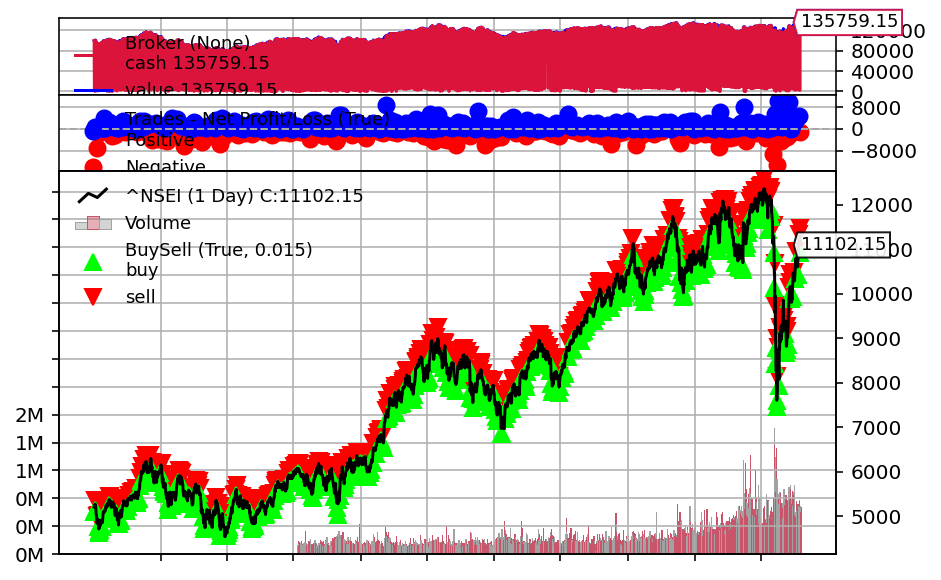

In [ ]:
cerebro.plot() 

Start date,2010-01-12
End date,2020-07-30
Total months,122
,Backtest
Annual return,3.0%
Cumulative returns,35.8%
Annual volatility,12.6%
Sharpe ratio,0.30
Calmar ratio,0.09
Stability,0.64
Max drawdown,-33.1%


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


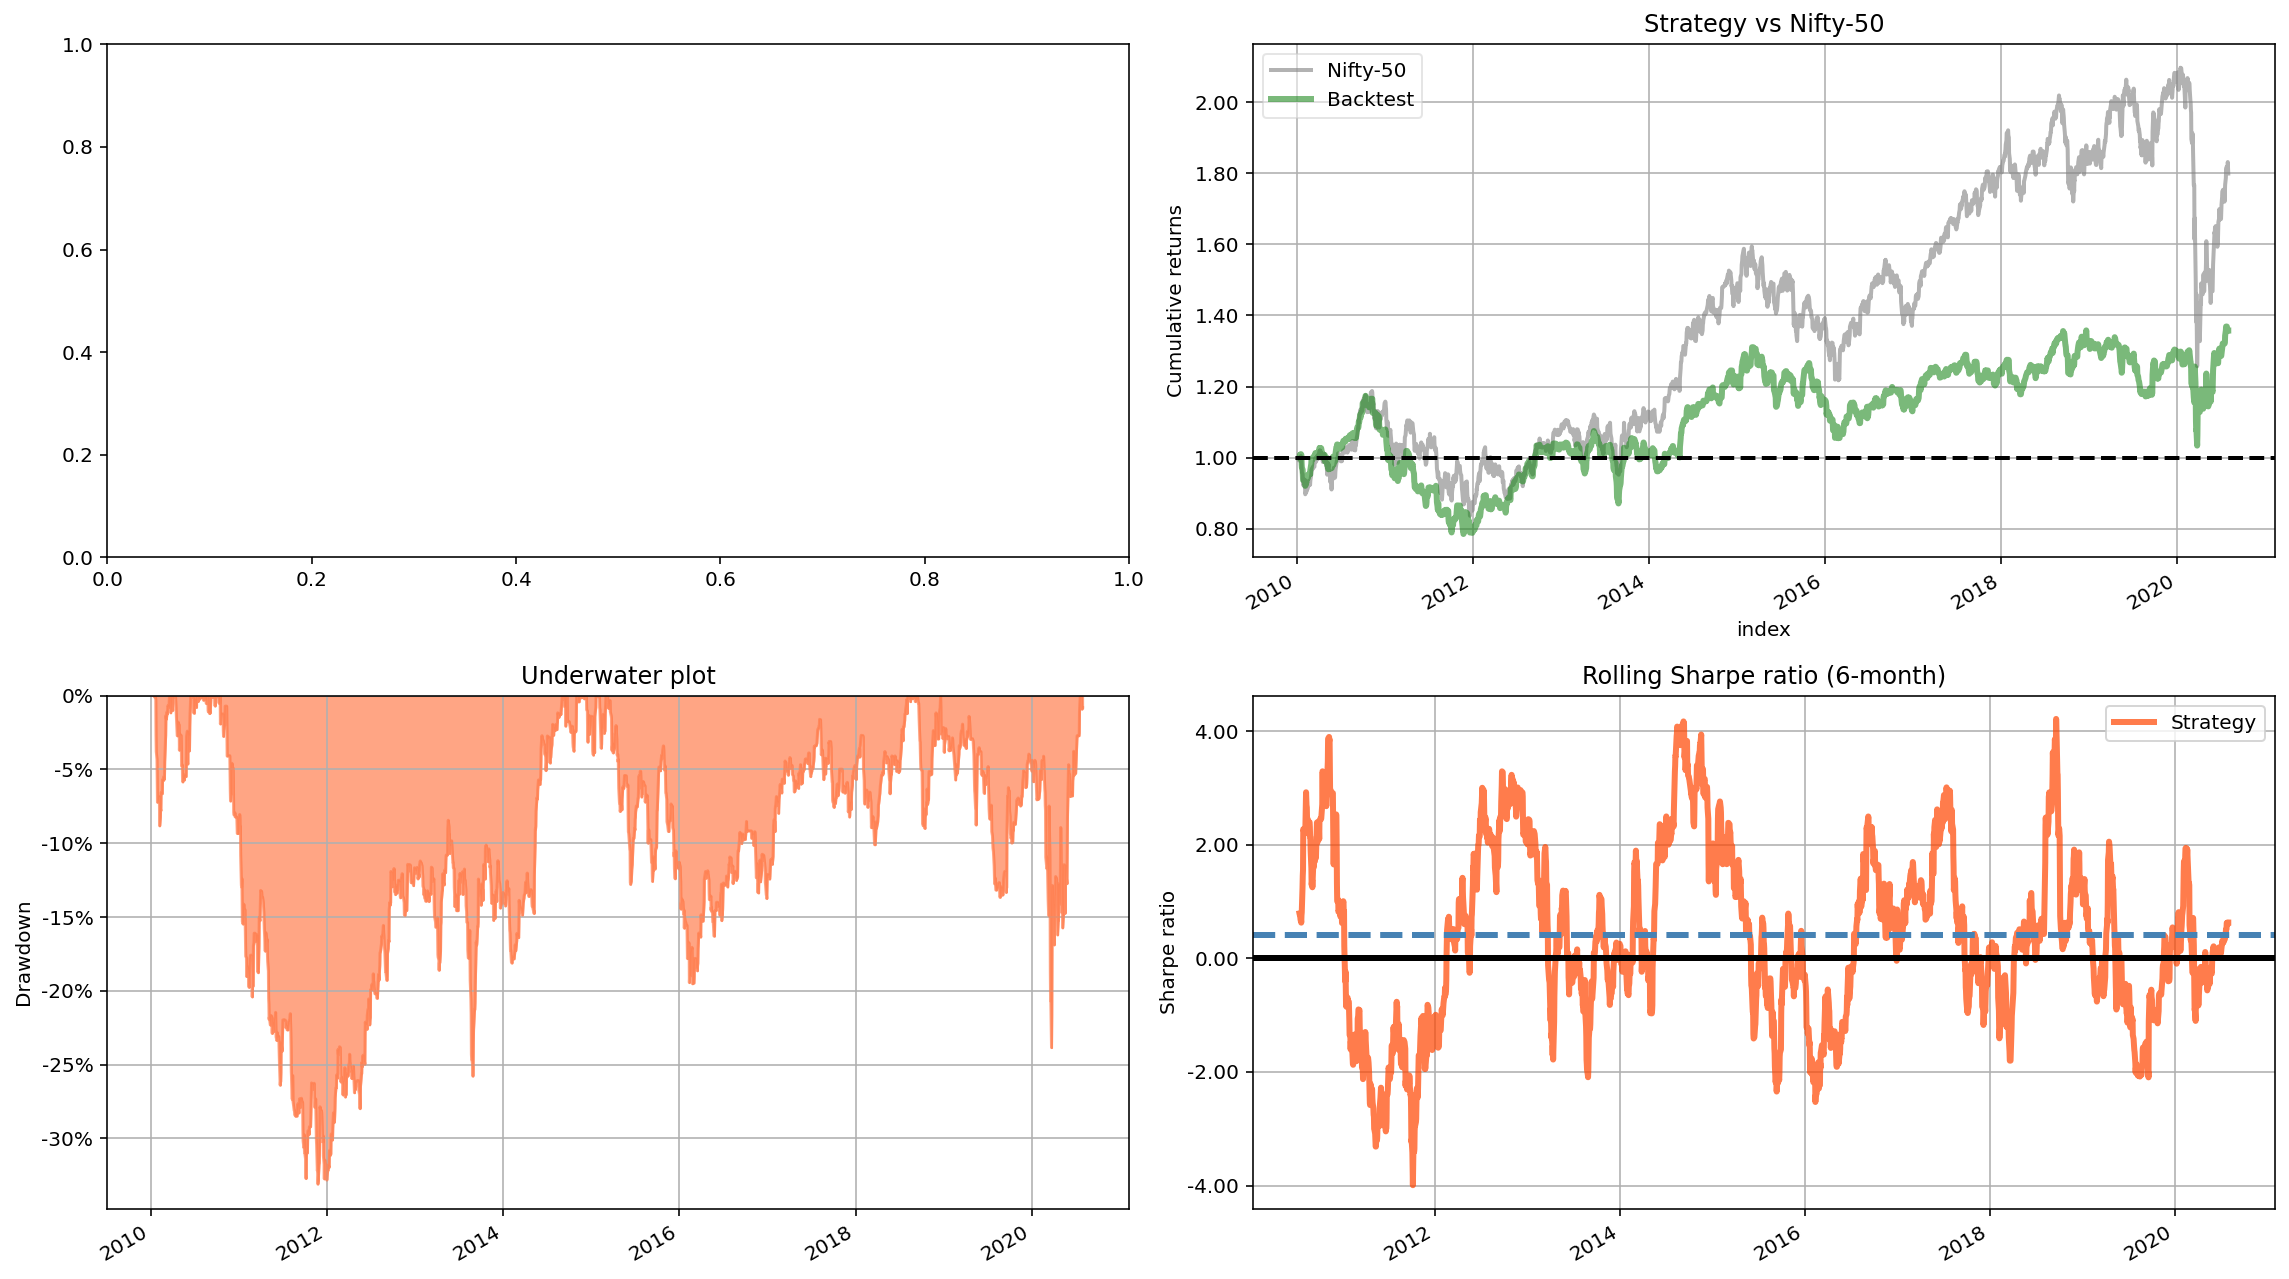

In [ ]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)
# get performance statistics for strategy
pf.show_perf_stats(returns)
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
#pf.plot_drawdown_periods(returns=returns, ax=axes[0])
#axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)
plt.grid(True)
plt.legend()
plt.tight_layout()

In [ ]:

import matplotlib
matplotlib.use('Agg') # Bypass the need to install Tkinter GUI framework
 
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
 
# Generate random data.
import yfinance as yf 

data_x = np.arange(start = 0, stop = 25, step = 1, dtype='int')
data_y = yf.download('AAPL', period='5y', interval ='1d')['Close']

# Find peaks(max).
peak_indexes = signal.argrelextrema(data_y.values, np.greater)
peak_indexes = peak_indexes[0]
 
# Find valleys(min).
valley_indexes = signal.argrelextrema(data_y.values, np.less)
valley_indexes = valley_indexes[0]
 
# Plot main graph.



[*********************100%***********************]  1 of 1 completed


In [ ]:
valley_indexes

array([   1,    6,   10,   12,   14,   17,   19,   21,   23,   34,   40,
         43,   48,   55,   58,   68,   72,   74,   79,   82,   84,   86,
         88,   92,   97,   99,  101,  106,  116,  119,  125,  130,  134,
        136,  140,  143,  146,  148,  153,  156,  160,  163,  166,  170,
        173,  181,  187,  191,  196,  203,  206,  208,  212,  215,  224,
        227,  239,  242,  244,  246,  250,  257,  259,  263,  267,  269,
        271,  273,  278,  281,  283,  285,  291,  297,  300,  307,  320,
        322,  325,  329,  332,  340,  343,  345,  348,  352,  355,  360,
        367,  373,  375,  378,  382,  384,  388,  393,  395,  399,  401,
        406,  411,  413,  416,  425,  427,  429,  432,  437,  442,  450,
        455,  465,  468,  477,  479,  481,  484,  488,  493,  499,  502,
        511,  514,  518,  521,  526,  529,  533,  535,  539,  542,  546,
        551,  554,  560,  562,  566,  569,  574,  579,  581,  584,  587,
        591,  597,  601,  607,  611,  616,  618,  6

AttributeError: ignored

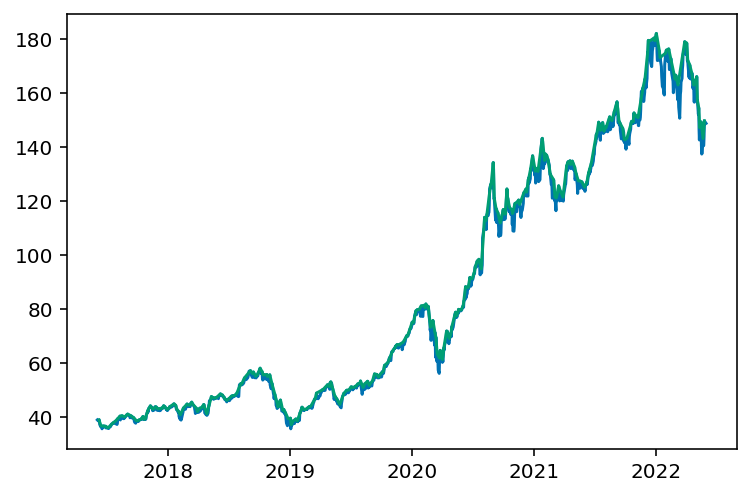

In [ ]:
peak_x = peak_indexes
peak_y = data_y[peak_indexes]

plt.plot(data_y)
plt.plot(peak_y)
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='green', label="Peaks")

In [ ]:
(fig, ax) = plt.subplots()
ax.plot(data_y)
plt.show() 
# Plot peaks.

peak_x = peak_indexes
peak_y = data_y[peak_indexes]
ax.plot(peak_x, peak_y, marker='o', linestyle='dashed', color='green', label="Peaks")


In [ ]:
 
# Plot valleys.
valley_x = valley_indexes
valley_y = data_y[valley_indexes]
ax.plot(valley_x, valley_y, marker='o', linestyle='dashed', color='red', label="Valleys")
 
